# Light shift Calculations

**These calculations come from the following paper:**  
https://arxiv.org/pdf/physics/9902072v1.pdf  
OPTICAL DIPOLE TRAPS FOR NEUTRAL ATOMS  
Rudolf Grimm and Matthias Weidemu¨ller 


## Setup

### Imports

In [44]:
import numpy as np

### Preferences

In [45]:
import numpy as np 
from numpy import array as arr
import pandas as pd
import plotly.offline as pltly
pltly.init_notebook_mode(connected=True)
from plotly import graph_objs as go
import math
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings 
warnings.filterwarnings('module')
from datetime import datetime
import uncertainties.unumpy
import IPython
import pandas as pd
import pickle

from matplotlib.pyplot import *
from matplotlib import rcParams
from matplotlib import style
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# ## set matplotlib plot defaults :D
# Style controls many default colors in matplotlib plots.
# Change the following if you don't like dark backgrounds. Many other options.
import matplotlib as mpl

if False:
    # My Dark Settings
    style.use(['dark_background'])
    c = '#0A0A0A'
    mpl.rcParams['axes.facecolor'] = '#000000'
    mpl.rcParams['figure.edgecolor'] = c
    mpl.rcParams['figure.facecolor'] = c
else:
    # My Light Settings
    style.use(['default'])
    c = '#FFFFFF'
    mpl.rcParams['axes.facecolor'] = c
    mpl.rcParams['figure.edgecolor'] = c
    mpl.rcParams['figure.facecolor'] = c  
# the default cycling of colors in this mode isn't very good.
#rcParams['axes.prop_cycle'] = ("cycler('color', ['r','c','g','#FFFFFF','b']) + cycler('marker', ['o','v','<','>','^'])")
### General
rcParams['figure.figsize'] = (25.0, 8.0)
rcParams['axes.grid'] = True
rcParams['axes.formatter.useoffset'] = False
rcParams['grid.alpha'] = 0.15
rcParams['axes.formatter.limits'] = (-3,3)
rcParams['image.cmap'] = 'viridis'
#rcParams['image.cmap'] = dark_viridis_cmap
# to see all available options, decomment this line.
# print(mpl.rcParams)
rcParams['font.size'] = 14
from matplotlib import cm
viridis = cm.get_cmap('viridis', 256)
dark_viridis = []
bl = 0.15
for i in range(256):
    dark_viridis.append(list(viridis(i)))
    dark_viridis[-1][0] = dark_viridis[-1][0] *(bl+(1-bl)*i/255)
    dark_viridis[-1][1] = dark_viridis[-1][1] *(bl+(1-bl)*i/255)
    dark_viridis[-1][2] = dark_viridis[-1][2] *(bl+(1-bl)*i/255)
dark_viridis_cmap = ListedColormap(dark_viridis)

## Constants

### General Physics & Math Constants

In [46]:
""" all in mks """
# planck's constant ?
h = 6.6260700e-34
# reduced planck's constant ?
hbar = 1.0545718e-34
# boltzman's constant ?
k_B = 1.3806488e-23;
# speed of light (exact)
c = 299792458
# Stephan-Boltzman constant, ?
sigma = 5.6704e-8
# atomic mass unit, ?
amu = 1.6605390e-27
# rubidium 87 mass, inexact
Rb87_M = 86.909180527 * amu
# use numpy
pi = np.pi
# gravity constant, inexact
g = 9.80665
# fundamental charge (charge of electron & proton), in coulombs, inexact
qe = 1.6021766208e-19
# Bohr Radius, in m
a0 = 0.52917721067e-10
# Electric constant, vacuum permitivity, in Farads per meter, exact
epsilon0 = 8.854187817e-12
# Magnetic Constant, vacuum permeability, in Henrys / meter or newtons / Amp^2, exact
mu0 = 4e-7 * pi

### Rubidium Constants

In [4]:
# linewidths, in s^-1
Rb87_D1Gamma = 36.10e6
Rb87_D1GammaUncertainty = 0.05e6
Rb87_D2Gamma = 38.11e6
Rb87_D2GammaUncertainty = 0.06e6
# for far-detuned approximations only.
# strictly, I should probably weight by clebsch-Gordon coefficients or something to get 
# a better far-detuned approximation.
Rb87_AvgGamma = (Rb87_D1Gamma + Rb87_D2Gamma)/2

# in mW/cm^2, 2-3', resonant & isotropic light.
Rb87_I_ResonantIsotropicSaturationIntensity = 3.576

# wavelengths are in vacuum.
# in m
Rb87_D2LineWavelength =         780.241209686e-9
Rb87_D2LineWavelengthUncertainty = 1.3e-17
# in Hz (1/s)
Rb87_D2LineFrequency =          384.2304844685e12
Rb87_D2LineFrequencyUncertainty = 6.2e3
# etc.
Rb87_D1LineWavelength = 794.9788509e-9
Rb87_D1LineWavelengthUncertainty = 8e-16
Rb87_D1LineFrequency = 377.1074635e12
Rb87_D1LineFrequencyUncertainty = 0.4e6

## Functions

### powerFromFrequency(frequency, waist, lightWavelength, latticeWavelength)

Assuming a gaussian beam and pi polarization, we have
$$
Power \equiv P\{\omega_t\} = -\frac{(2\pi)^2 mw_{\text{beam}}^2\omega_{\text{t}}^2\lambda^2}{8c^2\bigg(2 \frac{\Gamma_{D2}}{\omega_{D2}^3*\Delta_{D2}} + \frac{\Gamma_{D1}}{\omega_{D1}^3*\Delta_{D1}}\bigg)}
$$

In [32]:
def powerFromFrequency(frequency, waist, lightWavelength, latticeWavelength):    
    import numpy as np
    ### constants
    # in kg
    mass = 1.443*10**(-25)
    # in Hz
    d1TransitionFrequency = 384.2*10**12
    d2TransitionFrequency = 377.1*10**12
    c = 2.998*10**8
    # linewidth is equivalent to the 
    d1LineWidth = 36.1*10**6
    d2LineWidth = 38.11*10**6
    # from inputs & constants
    detuningFromD1 = d1TransitionFrequency - c / lightWavelength
    detuningFromD2 = d2TransitionFrequency - c / lightWavelength
    # calculation
    power = (((2*np.pi)**2 * mass * (waist**2) * (2*np.pi*frequency)**2*(latticeWavelength**2)) 
            / (8 * (c**2)* (2 * d2LineWidth/(d2TransitionFrequency**3*detuningFromD2) 
                                       + (d1LineWidth/(d1TransitionFrequency**3*detuningFromD1)))))
    return power

### trapFrequency(power, waist, lightWavelength, latticeWavelength)

We have
$$
\text{trap frequency} \equiv \nu_t = \frac{1}{\lambda_t} \sqrt{\frac{2D}{m_{rb}}}= \sqrt{\frac{8 c^2  P}{\lambda_t^2m_{rb}w_{waist}^2(2\pi)^4}\bigg(\frac{2\Gamma_{D2}}{\nu_{D2}^3\Delta_{D2}} + \frac{\Gamma_{D1}}{\nu_{D1}^3\Delta_{D1}}  \bigg)}
$$

In [33]:
def trapFrequency(power, waist, lightWavelength, latticeWavelength):
    mass = 1.443*10**(-25)
    depth = trapDepth(power, waist, lightWavelength)
    frequency = (1 /  latticeWavelength) * np.sqrt(2*depth / mass)
    return frequency



### trapDepth(power, waist, lightWavelength)

Assuming a Gaussian Beam, we have
$$
\text{Depth} \equiv D = \frac{4 c^2  P}{w_{waist}^2(2\pi)^4}\bigg(\frac{2\Gamma_{D2}}{\nu_{D2}^3\Delta_{D2}} + \frac{\Gamma_{D1}}{\nu_{D1}^3\Delta_{D1}}  \bigg)
$$

In [34]:
def trapDepth(power, waist, lightWavelength):
    """
    Assumes PI polarization (exchange 2->2+P and 1->1-P)
    """
    # in meters/second
    c = 2.998*10**8
    # in joule-seconds
    h = 6.626 * 10**-34
    # in Hz
    d1TransitionFrequency = 384.2*10**12
    d2TransitionFrequency = 377.1*10**12
    # natural linewidth is equivalent to the decay rate
    d1LineWidth = 36.1*10**6
    d2LineWidth = 38.11*10**6
    detuningFromD1 = d1TransitionFrequency - c / lightWavelength
    detuningFromD2 = d2TransitionFrequency - c / lightWavelength
    chi = (d1LineWidth/(d1TransitionFrequency**3 * detuningFromD1) + 2 * d2LineWidth / (d2TransitionFrequency**3 * detuningFromD2))
    depth = ((4 * c**2 * power) / (waist**2 * (2*np.pi)**4)) * chi
    return depth
      

### scatterRate(power, waistAtTrap, lightWavelength)

$$
\text{Scattering Rate} \equiv \Gamma_{\text{sc}} = \frac{4c^2P}{\hbar w^2(2\pi)^5}\bigg(\frac{2 \Gamma_{D2}^2}{\Delta_{D2}^2 \nu_{D2}^3}+\frac{\Gamma_{D1}^2}{\Delta_{D2}^2 \nu_{D2}^3}\bigg)
$$

In [35]:
def scatterRate(power, waist, lightWavelength):
    # natural linewidth is equivalent to the decay rate
    deltaD1 = Rb87_D1LineFrequency - c / lightWavelength
    deltaD2 = Rb87_D2LineFrequency - c / lightWavelength
    #print(deltaD2, deltaD1)
    scatteringRate = (c**2 * 4 * power / (hbar * waist**2)*(2 * pi)**(-5)
                    * (2 * Rb87_D2Gamma**2 / (deltaD2**2*Rb87_D2LineFrequency**3) 
                       + Rb87_D1Gamma**2 / (deltaD1**2*Rb87_D1LineFrequency**3)))
    return scatteringRate    

### Tweezer Depth

In [36]:
def tweezerDepth(power, waist, wavelength):
    mass = 1.443*10**(-25)
    # in Hz
    nuD1 = 384.2*10**12
    nuD2 = 377.1*10**12
    c = 2.998*10**8
    # linewidth is equivalent to the 
    gammaD1 = 36.1*10**6
    gammaD2 = 38.11*10**6
    # from inputs & constants
    deltaD1 = nuD1 - c / wavelength
    deltaD2 = nuD2 - c / wavelength
    # calculation
    chi = (2 * gammaD2 / (deltaD2 * nuD2**3) + gammaD1 / (deltaD1 * nuD1**3))
    depth = c**2 * power / ((2*np.pi)**4*waist**2) * chi
    # in joules
    return depth

### Tweezer+Lattice Depth

In [37]:
def tweezerPlusLatticeDepth(tweezerPower, tweezerWaist, tweezerWavelength, latticePower, latticeWaist, 
                            latticeLightWavelength, latticeTrapWavelength, z, latticePhase):
    mass = 1.443*10**(-25)
    # in Hz
    nuD1 = 384.2*10**12
    nuD2 = 377.1*10**12
    c = 2.998*10**8
    # linewidth is equivalent to the 
    gammaD1 = 36.1*10**6
    gammaD2 = 38.11*10**6
    # from inputs & constants
    deltaD1Tweezer = nuD1 - c / tweezerWavelength
    deltaD2Tweezer = nuD2 - c / tweezerWavelength
    deltaD1Lattice = nuD1 - c / latticeLightWavelength
    deltaD2Lattice = nuD2 - c / latticeLightWavelength
    # calculation
    chiTweezer = (2 * gammaD2 / (deltaD2Tweezer * nuD2**3) + gammaD1 / (deltaD1Tweezer * nuD1**3))
    chiLattice = (2 * gammaD2 / (deltaD2Lattice * nuD2**3) + gammaD1 / (deltaD1Lattice * nuD1**3))
    
    commonFactor = c**2/(2*np.pi)**4
    tweezerRayleighRange = np.pi * tweezerWaist**2 / tweezerWavelength
    tweezerDynamicWaist = tweezerWaist * np.sqrt(1 + (z/tweezerRayleighRange)**2)
    tweezerDepth = commonFactor * tweezerPower * chiTweezer / tweezerDynamicWaist**2
    latticeDepth = commonFactor * 4 * latticePower * chiLattice / latticeWaist**2 * (np.cos(2*np.pi / latticeTrapWavelength * z + latticePhase))**2
    return tweezerDepth + latticeDepth
    

### Tweezer Frequency

In [38]:
def tweezerFrequency(power, waist, wavelength):
    mass = 1.443*10**(-25)
    # in Hz
    nuD1 = 384.2*10**12
    nuD2 = 377.1*10**12
    c = 2.998*10**8
    # linewidth is equivalent to the 
    gammaD1 = 36.1*10**6
    gammaD2 = 38.11*10**6
    # from inputs & constants
    deltaD1 = nuD1 - c / wavelength
    deltaD2 = nuD2 - c / wavelength
    # calculation
    chi = (2 * gammaD2 / (deltaD2 * nuD2**3) + gammaD1 / (deltaD1 * nuD1**3))
    nut = c * wavelength / ((2 * np.pi)**4 * waist**3) * np.sqrt(8 * power * chi / mass)
    return nut
    #omegat = np.sqrt(chi * (2 * power * c**2 * wavelength ** 2) / (mass * np.pi**6 * waist**6))
    #print(np.sqrt((c**2 / (mass * (2 * np.pi)**3)) * chi * (power * wavelength**2/(np.pi**3*waist**6))) / (2*np.pi))
    #return omegat/(2*np.pi)

In [39]:
intensity = 3.185 * 10**11 * 0.00715
waist = 707*10**-9
power = intensity * waist**2 * np.pi/2
print(str(tweezerFrequency(power, 700*10**-9, 850*10**-9)*10**-3) + "khz")

42.044483091970086khz


### Lattice + Tweezer

In [40]:
def latticeTweezerTrapFrequency(tweezerPower, tweezerWaist, tweezerLightWavelength, latticePower,
                                latticeWaist, latticeLightWavelength, latticeWavelength):
    mass = 1.443*10**(-25)
    # in Hz
    nuD1 = 384.2*10**12
    nuD2 = 377.1*10**12
    c = 2.998*10**8
    # linewidth is equivalent to the 
    gammaD1 = 36.1*10**6
    gammaD2 = 38.11*10**6
    # from inputs & constants
    deltaD1Tweezer = - nuD1 + c / tweezerLightWavelength
    deltaD2Tweezer = - nuD2 + c / tweezerLightWavelength
    deltaD1Lattice = - nuD1 + c / latticeLightWavelength
    deltaD2Lattice = - nuD2 + c / latticeLightWavelength
    # calculation
    chiTweezer = (2 * gammaD2 / (deltaD2Tweezer * nuD2**3) + gammaD1 / (deltaD1Tweezer * nuD1**3))
    chiLattice = (2 * gammaD2 / (deltaD2Lattice * nuD2**3) + gammaD1 / (deltaD1Lattice * nuD1**3))
    omegat = np.sqrt(-(c**2 / (mass * (2 * np.pi)**3)) * (chiLattice * 16 * np.pi * latticePower / (latticeWaist**2 * latticeWavelength**2)
                     + chiTweezer * tweezerPower * tweezerLightWavelength**2/(np.pi**3*tweezerWaist**6)))
    return omegat/(2*np.pi)
    

In [41]:
intensity = 3.185 * 10**11 * 0.00715
waist = 707*10**-9
power = intensity * waist**2 * np.pi/2
print(latticeTweezerTrapFrequency(power, waist, 0 * 1.4 * 0.8 * 0.8 * 0.9, 170*10**-6, 850*10**-9, 850*np.sqrt(2) * 10**-9))
print(trapFrequency(1.4*0.8*0.8*0.9, 170*10**-6, 850*10**-9, 850 * np.sqrt(2)*10**-9))
print(powerFromFrequency(70000, 170*10**-6, 850*10**-9, 850 * np.sqrt(2)*10**-9))

TypeError: latticeTweezerTrapFrequency() missing 1 required positional argument: 'latticeWavelength'

## Calculations

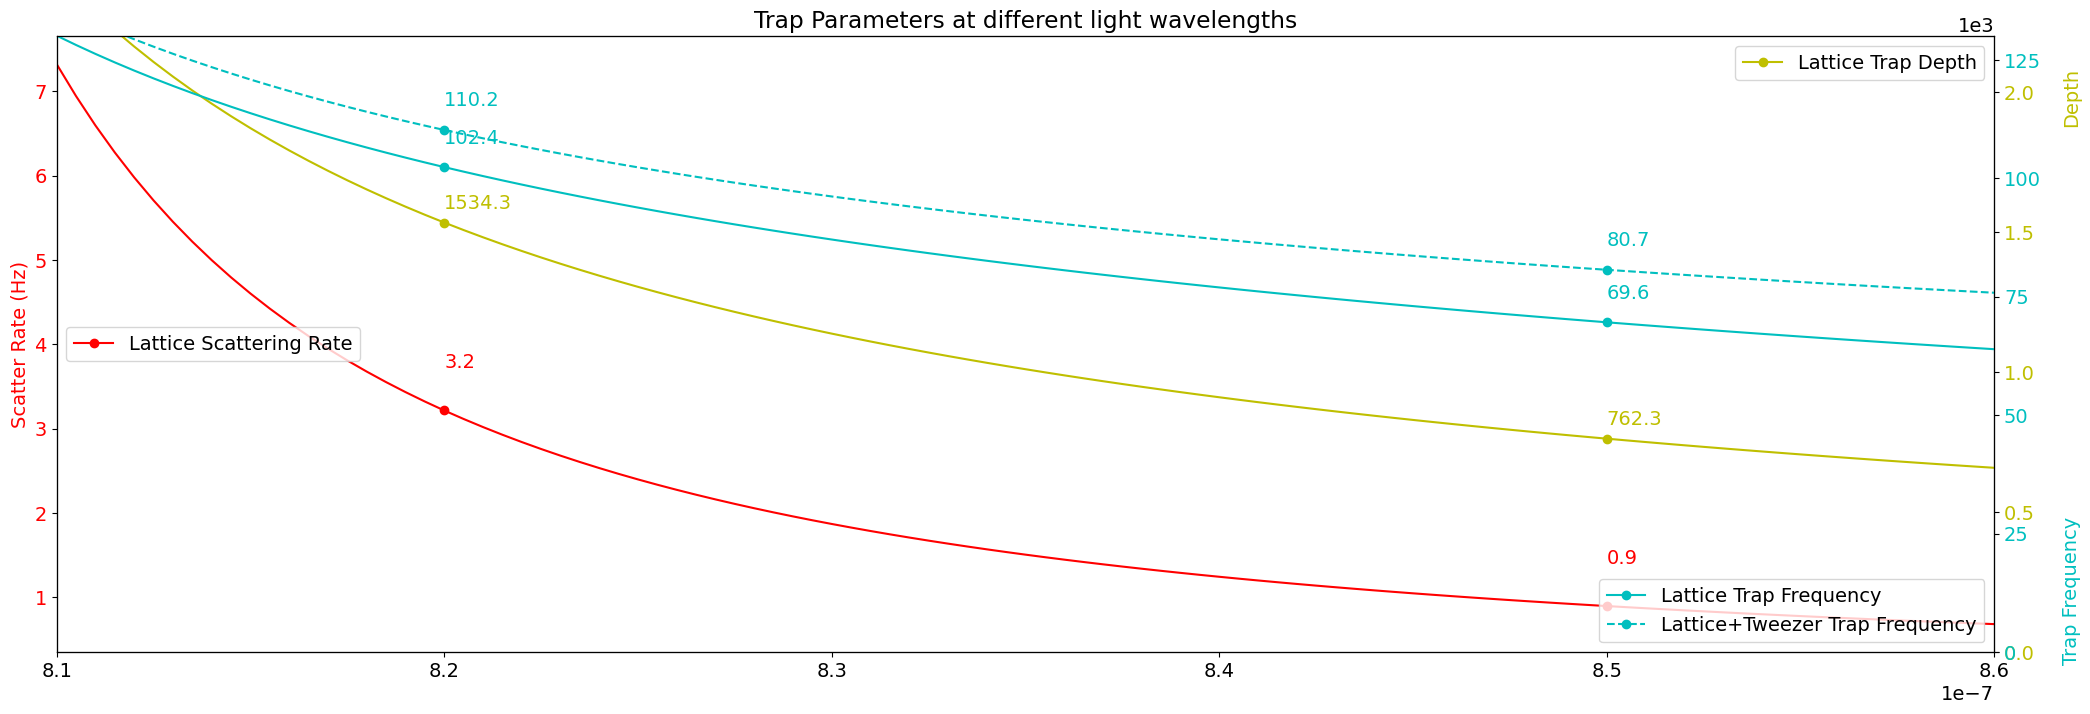

In [47]:
# in hertz
desiredTrapFrequency = 75*10**3
# waist is in meters
trapWaist = 170*10**(-6)
h = 6.626*10**-34
# (in meters) This is different from the wavelength because of the bowtie configuration.
powerEstimate = 1.4 * 0.8 * 0.8 * 0.9
# 
tweezerWavelength = 850*10**-9
tweezerIntensity = 3.185 * 10**11 * 0.00715
tweezerWaist = 707*10**-9
tweezerPower = tweezerIntensity * tweezerWaist**2 * np.pi/2

lightWavelengths = np.linspace(810*10**-9, 860*10**-9, 101)
latticeWavelengths = np.sqrt(2) * lightWavelengths

trapFrequencies = trapFrequency(powerEstimate, trapWaist, lightWavelengths, latticeWavelengths)
totalTrapFrequencies = latticeTweezerTrapFrequency(power, waist, tweezerWavelength, powerEstimate, trapWaist, lightWavelengths, latticeWavelengths)
depths = trapDepth(powerEstimate, trapWaist, lightWavelengths)
scatterRates = scatterRate(powerEstimate, trapWaist, lightWavelengths)
index850 = np.where(lightWavelengths==850*10**-9)[0][0]
index820 = np.where(lightWavelengths==820*10**-9)[0][0]
fig, ax1 = plt.subplots()
plt.plot(lightWavelengths, scatterRates, 'r', marker='o', markevery=[index850, index820], label='Lattice Scattering Rate')
ax1.set_ylabel('Scatter Rate (Hz)', color='r')
for tl in ax1.get_yticklabels():
    tl.set_color('r')
ax1.grid(color='r')
ax1.annotate("{:.1f}".format(scatterRates[index850]),
             xy=(lightWavelengths[index850], scatterRates[index850]+0.5), color='r')
ax1.annotate("{:.1f}".format(scatterRates[index820]),
             xy=(lightWavelengths[index820], scatterRates[index820]+0.5), color='r')
ax1.legend(loc=6)
# second plot
ax2 = ax1.twinx()
plt.plot(lightWavelengths, depths*10**-3/h, 'y', marker='o', markevery=[index850, index820], label='Lattice Trap Depth')
ax2.set_ylabel('Depth', color='y')
for tl in ax2.get_yticklabels():
    tl.set_color('y')
ax2.set_yticks(np.arange(0,2200,500))
ax2.grid(color='y')
ax2.set_ylim(0,2200)
ax2.yaxis.set_label_coords(1.035, 0.9)
ax2.annotate("{:.1f}".format(depths[index850]*10**-3/h),
             xy=(lightWavelengths[index850], depths[index850]*10**-3/h+50), color='y')
ax2.annotate("{:.1f}".format(depths[index820]*10**-3/h),
             xy=(lightWavelengths[index820], depths[index820]*10**-3/h+50), color='y')
ax2.legend(loc=1)
# third
ax3 = ax1.twinx()
plt.plot(lightWavelengths, trapFrequencies*10**-3, 'c', marker='o', markevery=[index850, index820], label='Lattice Trap Frequency')
plt.plot(lightWavelengths, totalTrapFrequencies*10**-3, 'c', linestyle='--', marker='o', markevery=[index850, index820], label='Lattice+Tweezer Trap Frequency')
ax3.set_ylabel('Trap Frequency', color='c')
for tl in ax3.get_yticklabels():
    tl.set_color('c')
ax3.set_yticks(np.arange(0,130,25))
ax3.grid(color='c')
ax3.set_ylim(0,130)
ax3.yaxis.set_label_coords(1.035, 0.1)
ax3.annotate("{:.1f}".format(trapFrequencies[index850]*10**-3),
             xy=(lightWavelengths[index850], trapFrequencies[index850]*10**-3+5), color='c')
ax3.annotate("{:.1f}".format(trapFrequencies[index820]*10**-3),
             xy=(lightWavelengths[index820], trapFrequencies[index820]*10**-3+5), color='c')
ax3.annotate("{:.1f}".format(totalTrapFrequencies[index850]*10**-3),
             xy=(lightWavelengths[index850], totalTrapFrequencies[index850]*10**-3+5), color='c')
ax3.annotate("{:.1f}".format(totalTrapFrequencies[index820]*10**-3),
             xy=(lightWavelengths[index820], totalTrapFrequencies[index820]*10**-3+5), color='c')


ax3.set_xlim(810*10**-9, 860*10**-9)
ax3.legend(loc=4)
plt.title('Trap Parameters at different light wavelengths');

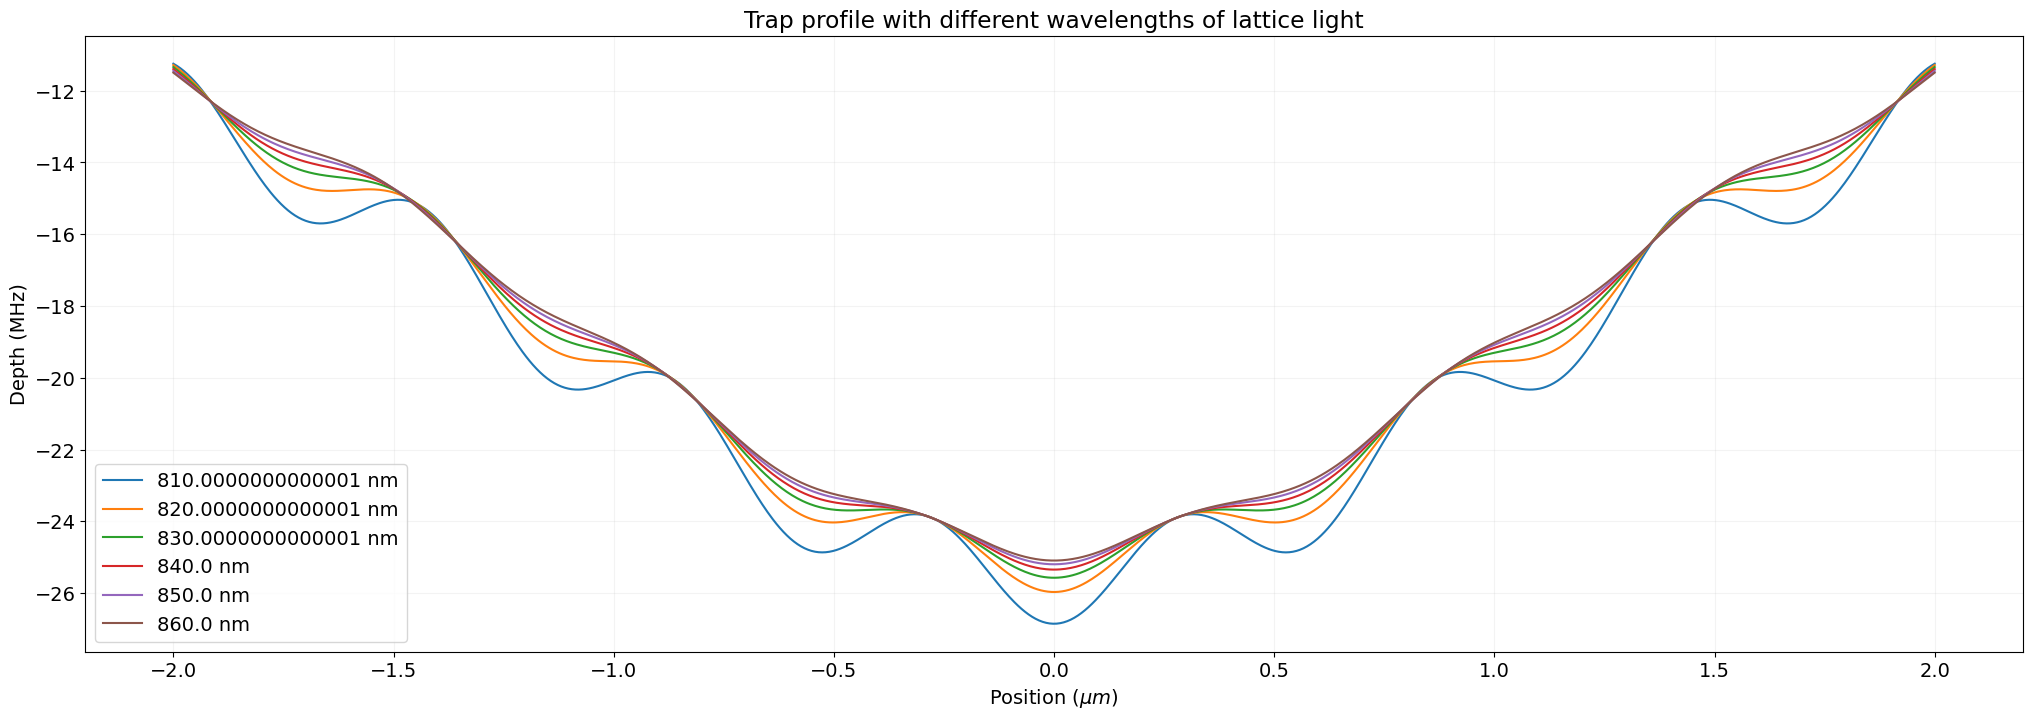

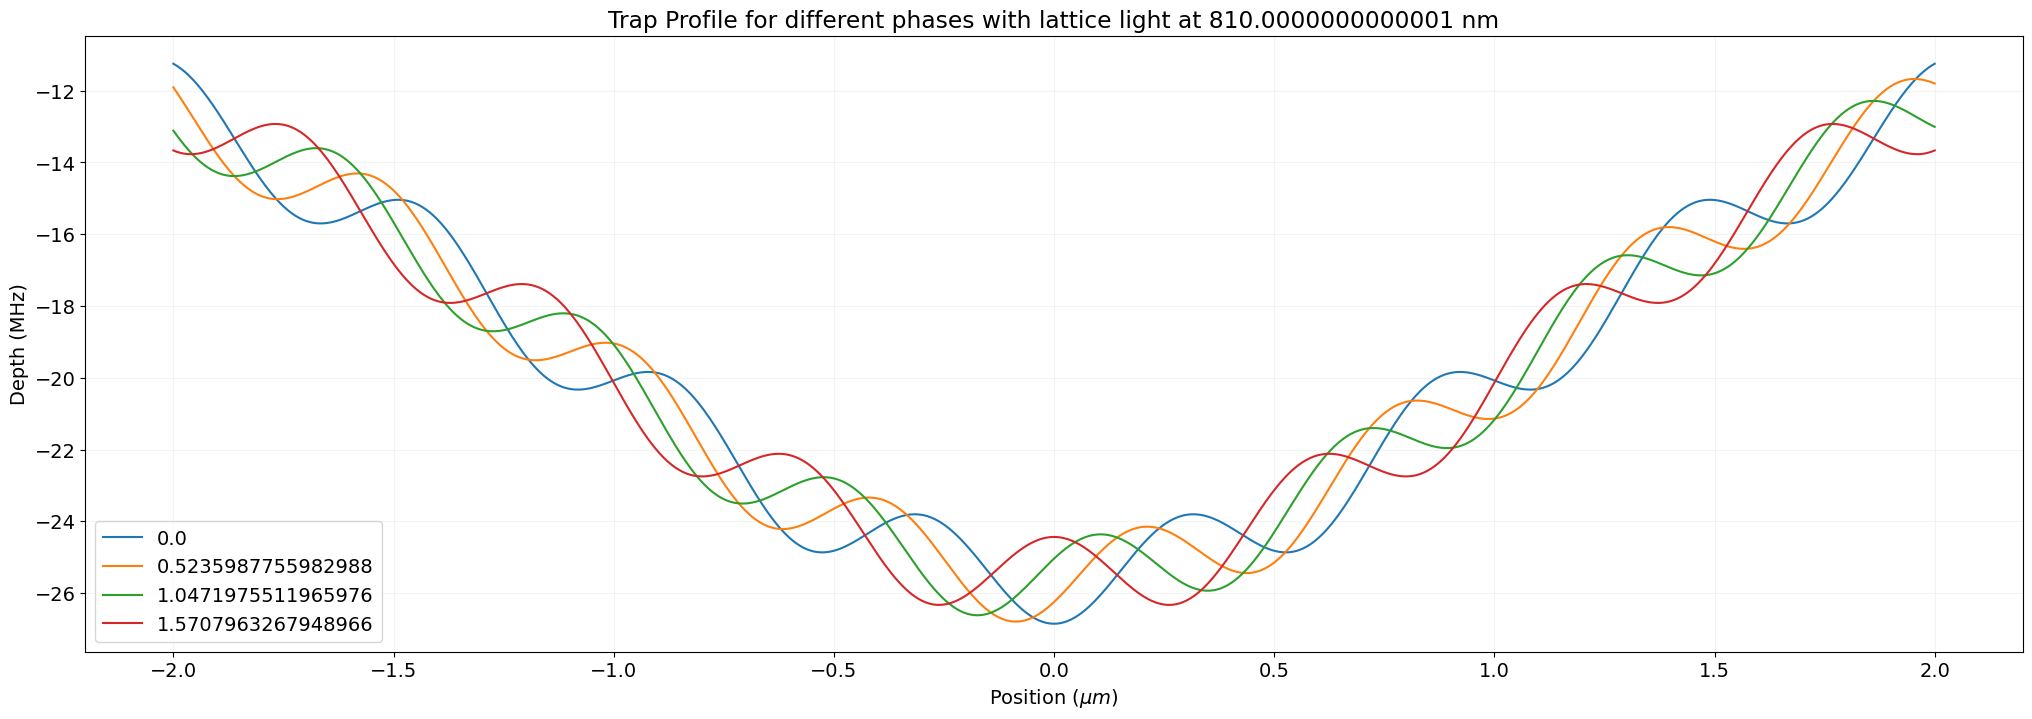

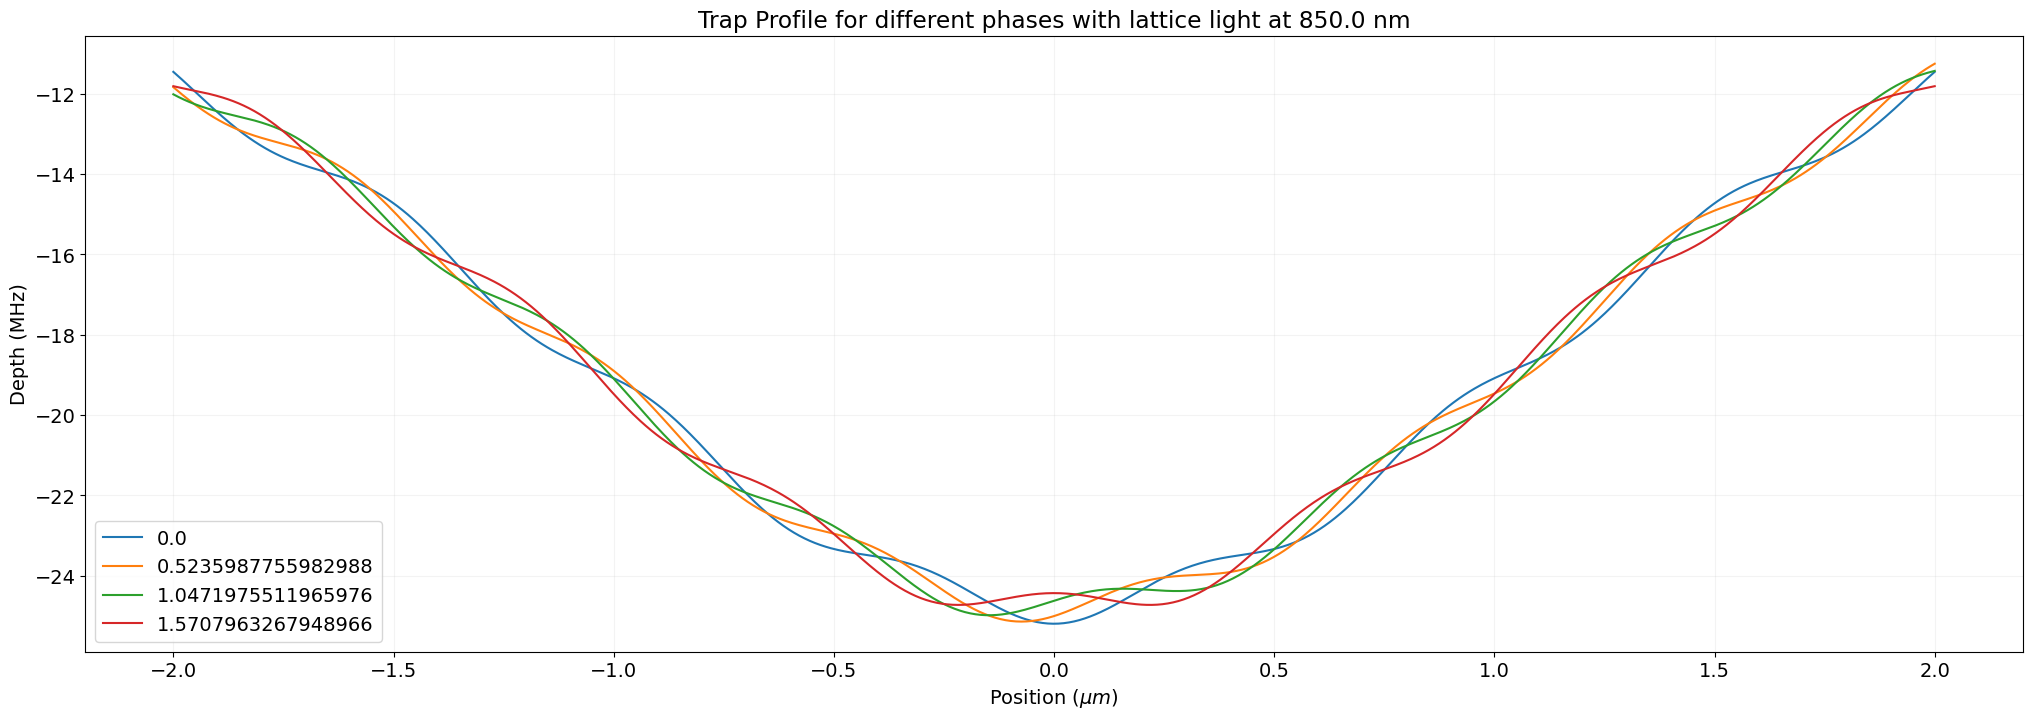

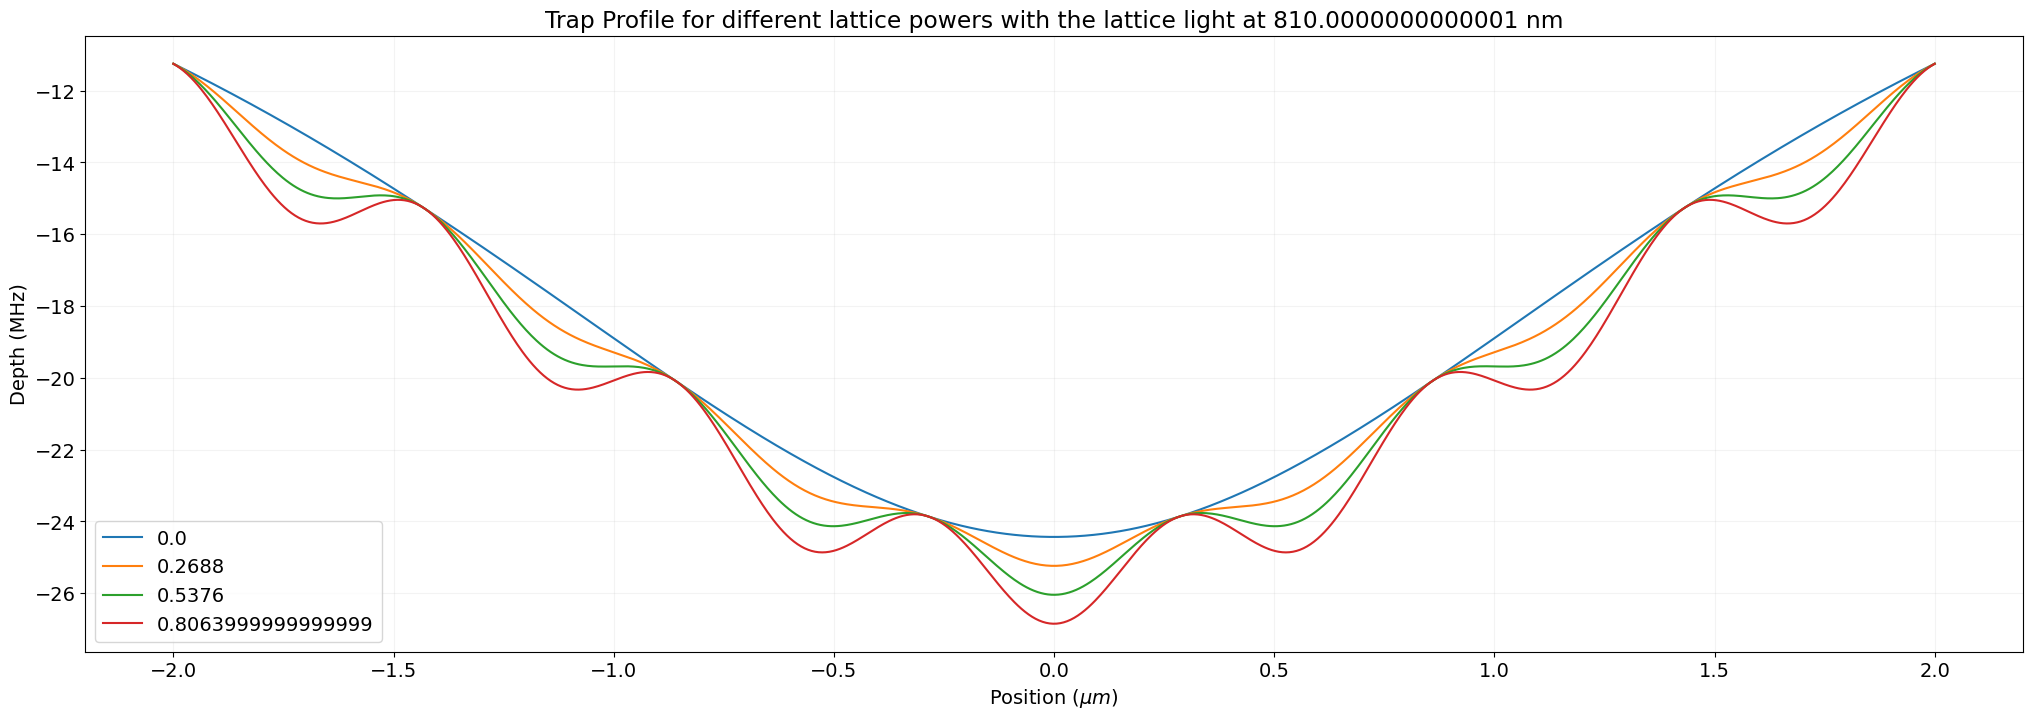

In [49]:
trapWaist = 170*10**(-6)
h = 6.626*10**-34
# (in meters) This is different from the wavelength because of the bowtie configuration.
powerEstimate = 1.4 * 0.8 * 0.8 * 0.9
# 
tweezerWavelength = 850*10**-9
tweezerIntensity = 3.185 * 10**11 * 0.00715
tweezerWaist = 707*10**-9
latticeWaist = 170*10**-6
tweezerPower = tweezerIntensity * tweezerWaist**2 * np.pi/2

positions = np.linspace(-2*10**-6, 2*10**-6, 1000)

lightWavelengths = np.linspace(810 * 10**-9, 860 * 10**-9, 6)
latticeWavelengths = np.sqrt(2) * lightWavelengths

depthProfile = np.zeros([len(lightWavelengths), len(positions)])

phases = np.linspace(0, np.pi/2, 4)

plt.figure(1)
for wavelengthInc in range(len(lightWavelengths)):
    depthProfile[wavelengthInc] = tweezerPlusLatticeDepth(tweezerPower, tweezerWaist, tweezerWavelength, powerEstimate,
                                                          latticeWaist, lightWavelengths[wavelengthInc], latticeWavelengths[wavelengthInc], positions, 0)
    plt.plot(positions * 10**6, -depthProfile[wavelengthInc] / (h * 10**6), label=str(lightWavelengths[wavelengthInc]*10**9) + ' nm')
plt.title('Trap profile with different wavelengths of lattice light')
plt.xlabel(r'Position $(\mu m)$')
plt.ylabel('Depth (MHz)')
plt.legend()

plt.figure(2)
for phaseInc in range(len(phases)):
    depthProfile[phaseInc] = tweezerPlusLatticeDepth(tweezerPower, tweezerWaist, tweezerWavelength, powerEstimate,
                                                          latticeWaist, lightWavelengths[0], latticeWavelengths[0], positions, phases[phaseInc])
    plt.plot(positions * 10**6, -depthProfile[phaseInc] / (h * 10**6), label=str(phases[phaseInc]))

plt.title('Trap Profile for different phases with lattice light at ' + str(lightWavelengths[0]*10**9) + ' nm')
plt.xlabel(r'Position $(\mu m)$')
plt.ylabel('Depth (MHz)')
plt.legend()

plt.figure(3)
for phaseInc in range(len(phases)):
    depthProfile[phaseInc] = tweezerPlusLatticeDepth(tweezerPower, tweezerWaist, tweezerWavelength, powerEstimate,
                                                          latticeWaist, lightWavelengths[-2], latticeWavelengths[-2], positions, phases[phaseInc])
    plt.plot(positions * 10**6, -depthProfile[phaseInc] / (h * 10**6), label=str(phases[phaseInc]))
plt.title('Trap Profile for different phases with lattice light at ' + str(lightWavelengths[-2]*10**9) + ' nm')
plt.xlabel(r'Position $(\mu m)$')
plt.ylabel('Depth (MHz)')
plt.legend();

plt.figure(4)
powers = np.linspace(0, powerEstimate, 4)
for powerInc in range(len(powers)):
    depthProfile[powerInc] = tweezerPlusLatticeDepth(tweezerPower, tweezerWaist, tweezerWavelength, powers[powerInc],
                                                     latticeWaist, lightWavelengths[0], latticeWavelengths[0], positions, 0)
    plt.plot(positions * 10**6, -depthProfile[powerInc] / (h * 10**6), label=str(powers[powerInc]))

plt.title('Trap Profile for different lattice powers with the lattice light at ' + str(lightWavelengths[0]*10**9) + ' nm')
plt.xlabel(r'Position $(\mu m)$')
plt.ylabel('Depth (MHz)')
plt.legend();



### Calculating trap depth at different NAs and powers for simple tweezers

Wednesday, April 26th, 2017, for attempting to trap a bunch of atoms.

In [ ]:
na = 0.25
waist = 850e-9 / ((3.1415/2)*na)
power = 30e-3

print(waist)

#intensity = 3.185e11 * 0.00715
#waist = 707*10**-9
#power = intensity * waist**2 * np.pi/2
print(tweezerDepth(power, waist, 850*10**-9) / (6.626*10**-34 * 10**6), 'MHz')

### Calculating Scattering of tweezer light in very deep tweezer

In [29]:
scatterRate(200e-3, 0.6e-6, 850e-9) * 0.1

31533475056735.312 24410454088235.312


1784.6767104142884